# MSP430 SCA

This code was developed to aid in performing a side channel attack (SCA) on AES128 encryption on an MSP430. Code from the following sources was either directly copied or used as an example for this code:
- https://wiki.newae.com/V4:Tutorial_B6_Breaking_AES_(Manual_CPA_Attack)
- Chatgpt

## Library Import

In [1]:
# for numpy array and plotting
import numpy as np
import matplotlib.pyplot as plt

# for list of plaintext
import os

# for converting from .mat to .py
import scipy.io as sio

## Data Preprocessing

### List plaintext

The goal of this section is to create a list of the plaintexts used for each power trace. This is so that the SCA algorithm knows which plaintext to use for each power trace when it computes the power consumed for Sbox lookup. In preliminary testing, we manually saved 10 power traces with 10 different plaintext values (not nearly enough, but needed for proof of concept). The 10 power traces are saved in the file that is given as the folder path, in this case 'C:/Users/ktrippe/OneDrive - University of Arkansas/Trulogic/SCA_AES/MSP430_sample_power_traces_mat_only'. 

*Important assumptions about the contents of the folder:*
- Only .mat files are included in the file
- Filenames follow this convention exactly: "plaintext + \_math1 (or some oscilloscope channel name) + .mat"

In [2]:
folder_path = 'C:/Users/ktrippe/OneDrive - University of Arkansas/Trulogic/SCA_AES/MSP430_sample_power_traces_mat_only'

all_items = os.listdir(folder_path)

file_names = [item for item in all_items if os.path.isfile(os.path.join(folder_path, item))]

for filename in file_names:
    print(filename)
    
len(file_names)

01112233445566778899aabbccddeeff_math1.mat
3e2711fa9f3d4644788eaa2b0c521407_math1.mat
470f41a80f03288e9137ca5c98a112bd_math1.mat
8a35ab20f269b4e766311ea50f81cb94_math1.mat
8c9c074b6f3e37d44b7fd6a9f6a52986_math1.mat
9a7d1403edfa9b2757e06ce0ebc41547_math1.mat
ab3fb4269f71c34d9eb572de0798ff10_math1.mat
b22e43d3f76ce1bc357c3ee5ddd7d3c6_math1.mat
b9f2eea46873d70fda65257c37908b66_math1.mat
c98ec447a1f46cecd8e9990dca42454d_math1.mat


10

### Manual creation of textin numpy array

In this preliminary round of testing, the plaintexts were stored as string variables in the filename of each file. The desired result was a list of two-byte hex numbers represented as binary numbers. This is because the SCA algorithm used later uses this input format for the list of plaintexts. Since there weren't many files in preliminary testing, this could be done manually for potential debugging purposes.

In [3]:
textin_man = [[1, 17, 34, 51, 68, 85, 102, 119, 136, 153, 170, 187, 204, 221, 238, 255], [62, 39, 17, 250, 159, 61, 70, 68, 120, 142, 170, 43, 12, 82, 20, 7], [71, 15, 65, 168, 15, 3, 40, 142, 145, 55, 202, 92, 152, 161, 18, 189], [138, 53, 171, 32, 242, 105, 180, 231, 102, 49, 30, 165, 15, 129, 203, 148], [140, 156, 7, 75, 111, 62, 55, 212, 75, 127, 214, 169, 246, 165, 41, 134], [154, 125, 20, 3, 237, 250, 155, 39, 87, 224, 108, 224, 235, 196, 21, 71], [171, 63, 180, 38, 159, 113, 195, 77, 158, 181, 114, 222, 7, 152, 255, 16], [178, 46, 67, 211, 247, 108, 225, 188, 53, 124, 62, 229, 221, 215, 211, 198], [185, 242, 238, 164, 104, 115, 215, 15, 218, 101, 37, 124, 55, 144, 139, 102], [201, 142, 196, 71, 161, 244, 108, 236, 216, 233, 153, 13, 202, 66, 69, 77]]
textin_man

[[1, 17, 34, 51, 68, 85, 102, 119, 136, 153, 170, 187, 204, 221, 238, 255],
 [62, 39, 17, 250, 159, 61, 70, 68, 120, 142, 170, 43, 12, 82, 20, 7],
 [71, 15, 65, 168, 15, 3, 40, 142, 145, 55, 202, 92, 152, 161, 18, 189],
 [138, 53, 171, 32, 242, 105, 180, 231, 102, 49, 30, 165, 15, 129, 203, 148],
 [140, 156, 7, 75, 111, 62, 55, 212, 75, 127, 214, 169, 246, 165, 41, 134],
 [154, 125, 20, 3, 237, 250, 155, 39, 87, 224, 108, 224, 235, 196, 21, 71],
 [171, 63, 180, 38, 159, 113, 195, 77, 158, 181, 114, 222, 7, 152, 255, 16],
 [178, 46, 67, 211, 247, 108, 225, 188, 53, 124, 62, 229, 221, 215, 211, 198],
 [185, 242, 238, 164, 104, 115, 215, 15, 218, 101, 37, 124, 55, 144, 139, 102],
 [201, 142, 196, 71, 161, 244, 108, 236, 216, 233, 153, 13, 202, 66, 69, 77]]

### Automated conversion from filenames to hex numbers

Using the manually generated plaintext values, the automated conversion from the filenames to the two-byte decimal representations could be verified. This conversion was done from the list of filenames, not the manually generated list. The file naming convention is listed in the explanation for "List plaintext" section, and is directly related to the automatic generation of plaintext values. If the naming convention is different, this section should be as well. 

In [15]:
def extract_hex_from_filename(filename):
    # Extract the hex number from the filename
    hex_number = filename.split('_')[0].split('.')[0]
    return hex_number

def hex_to_decimal(hex_str):
    # Parse the hex number into pairs
    hex_pairs = [hex_str[i:i+2] for i in range(0, len(hex_str), 2)]

    # Convert the pairs to decimal
    decimal_numbers = [int(pair, 16) for pair in hex_pairs]

    return decimal_numbers

textin_auto = []

for filename in file_names:
    # Extract hex number from filename
    hex_number = extract_hex_from_filename(filename)

    # Convert hex to decimal
    decimal_numbers = hex_to_decimal(hex_number)
    textin_auto.append(decimal_numbers)

    # print(f"Filename: {filename}, Hex: {hex_number}, Decimal: {decimal_numbers}")
    
textin_auto

[[1, 17, 34, 51, 68, 85, 102, 119, 136, 153, 170, 187, 204, 221, 238, 255],
 [62, 39, 17, 250, 159, 61, 70, 68, 120, 142, 170, 43, 12, 82, 20, 7],
 [71, 15, 65, 168, 15, 3, 40, 142, 145, 55, 202, 92, 152, 161, 18, 189],
 [138, 53, 171, 32, 242, 105, 180, 231, 102, 49, 30, 165, 15, 129, 203, 148],
 [140, 156, 7, 75, 111, 62, 55, 212, 75, 127, 214, 169, 246, 165, 41, 134],
 [154, 125, 20, 3, 237, 250, 155, 39, 87, 224, 108, 224, 235, 196, 21, 71],
 [171, 63, 180, 38, 159, 113, 195, 77, 158, 181, 114, 222, 7, 152, 255, 16],
 [178, 46, 67, 211, 247, 108, 225, 188, 53, 124, 62, 229, 221, 215, 211, 198],
 [185, 242, 238, 164, 104, 115, 215, 15, 218, 101, 37, 124, 55, 144, 139, 102],
 [201, 142, 196, 71, 161, 244, 108, 236, 216, 233, 153, 13, 202, 66, 69, 77]]

## Conversion from .mat to .npy

### Testing mat_load

Now that the plaintexts are listed in the desired format, the contents of the files (power traces) need to be extracted and stored as numpy arrays rather than .mat files. This first block of code just tests one file to check the filename and size.

In [7]:
mat = sio.loadmat('C:/Users/ktrippe/OneDrive - University of Arkansas/Trulogic/SCA_AES/MSP430_sample_power_traces_mat_only/' + file_names[0])
# print(mat)
print("Loading file " + file_names[0])

mat_load = [[element for element in upperElement] for upperElement in mat['data']]
len(mat_load)

Loading file 01112233445566778899aabbccddeeff_math1.mat


2500000

### Load mat_list with data from traces

Assuming the file contains only the .mat files with power traces, this code can be used to iterate through files and store the content in a numpy array of traces.

In [8]:
mat_list = []

for j in range(len(file_names)):
    mat = sio.loadmat('C:/Users/ktrippe/OneDrive - University of Arkansas/Trulogic/SCA_AES/MSP430_sample_power_traces_mat_only/' + file_names[j])
    # print(mat)
    print("Loading file " + file_names[j])

    mat_load = [[element for element in upperElement] for upperElement in mat['data']]
    
    mat_temp = []
    length = len(mat_load) 
    for i in range(length): 
        mat_temp.append(mat_load[i][0])
    
    mat_list.append(mat_temp)
    i = 0
    print(f"j: {j}, i: {i}")
    print("Completed file " + file_names[j])
    
traces = np.array(mat_list) # convert the list to a NumPy array
traces.shape

Loading file 01112233445566778899aabbccddeeff_math1.mat
j: 0, i: 0
Completed file 01112233445566778899aabbccddeeff_math1.mat
Loading file 3e2711fa9f3d4644788eaa2b0c521407_math1.mat
j: 1, i: 0
Completed file 3e2711fa9f3d4644788eaa2b0c521407_math1.mat
Loading file 470f41a80f03288e9137ca5c98a112bd_math1.mat
j: 2, i: 0
Completed file 470f41a80f03288e9137ca5c98a112bd_math1.mat
Loading file 8a35ab20f269b4e766311ea50f81cb94_math1.mat
j: 3, i: 0
Completed file 8a35ab20f269b4e766311ea50f81cb94_math1.mat
Loading file 8c9c074b6f3e37d44b7fd6a9f6a52986_math1.mat
j: 4, i: 0
Completed file 8c9c074b6f3e37d44b7fd6a9f6a52986_math1.mat
Loading file 9a7d1403edfa9b2757e06ce0ebc41547_math1.mat
j: 5, i: 0
Completed file 9a7d1403edfa9b2757e06ce0ebc41547_math1.mat
Loading file ab3fb4269f71c34d9eb572de0798ff10_math1.mat
j: 6, i: 0
Completed file ab3fb4269f71c34d9eb572de0798ff10_math1.mat
Loading file b22e43d3f76ce1bc357c3ee5ddd7d3c6_math1.mat
j: 7, i: 0
Completed file b22e43d3f76ce1bc357c3ee5ddd7d3c6_math1.mat


(10, 2500000)

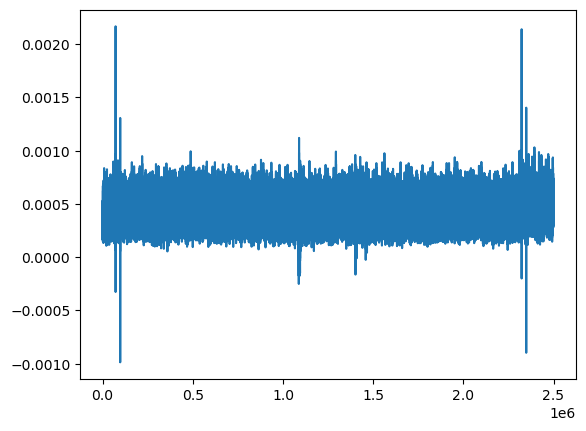

(2500000,)

In [9]:
plt.plot(traces[0])
plt.show()

np.shape(traces[0])

## SCA

### Sbox

The attack is being performed specifically on the power consumption during Sbox lookup, so the content of the Sbox is needed to compute an estimate of ideal power consumption.

In [10]:
#Lookup table for number of 1's in binary numbers 0-256
HW = [bin(n).count("1") for n in range(0,256)] 

sbox=(
0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76,
0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0,
0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15,
0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75,
0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84,
0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf,
0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8,
0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2,
0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73,
0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb,
0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79,
0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08,
0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a,
0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e,
0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf,
0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16)

### Attack

This is where the attack is performed. All of the variables used here should be taken care of in data preprocessing.

In [14]:
def intermediate(pt, keyguess):
    return sbox[pt ^ keyguess]

pt = textin_auto
# traces = np.load(r'MSP430_sample_traces.npy')
# pt = np.load(r'MSP430_sample_textin.npy')

numtraces = np.shape(traces)[0]-1
numpoint = np.shape(traces)[1]

#Use less than the maximum traces by setting numtraces to something
#numtraces = 15

bestguess = [0]*16
#Set 16 to something lower (like 1) to only go through a single subkey & save time!
for bnum in range(0, 1):
    cpaoutput = [0]*256
    maxcpa = [0]*256
    for kguess in range(0, 256):
        print ("Subkey %2d, hyp = %02x: "%(bnum, kguess))


        #Initialize arrays & variables to zero
        sumnum = np.zeros(numpoint)
        sumden1 = np.zeros(numpoint)
        sumden2 = np.zeros(numpoint)

        hyp = np.zeros(numtraces)
        for tnum in range(0, numtraces):
            hyp[tnum] = HW[intermediate(pt[tnum][bnum], kguess)]


        #Mean of hypothesis
        meanh = np.mean(hyp, dtype=np.float64)

        #Mean of all points in trace
        meant = np.mean(traces, axis=0, dtype=np.float64)

        #For each trace, do the following
        for tnum in range(0, numtraces):
            hdiff = (hyp[tnum] - meanh)
            tdiff = traces[tnum,:] - meant

            sumnum = sumnum + (hdiff*tdiff)
            sumden1 = sumden1 + hdiff*hdiff 
            sumden2 = sumden2 + tdiff*tdiff

        cpaoutput[kguess] = sumnum / np.sqrt( sumden1 * sumden2 )
        maxcpa[kguess] = max(abs(cpaoutput[kguess]))

        print (maxcpa[kguess])

    #Find maximum value of key
    bestguess[bnum] = np.argmax(maxcpa)

print ("Best Key Guess: ")
for b in bestguess: 
    print ("%02x "%b)

Subkey  0, hyp = 00: 
0.985527004396022
Subkey  0, hyp = 01: 
0.9890632908178352
Subkey  0, hyp = 02: 
0.9877158988626981
Subkey  0, hyp = 03: 
0.9843444438422815
Subkey  0, hyp = 04: 
0.9823889833573305
Subkey  0, hyp = 05: 
0.9868983730132362
Subkey  0, hyp = 06: 
0.988916272167368
Subkey  0, hyp = 07: 
0.9909503421424426
Subkey  0, hyp = 08: 
0.9942285524376494
Subkey  0, hyp = 09: 
0.9852816691788058
Subkey  0, hyp = 0a: 
0.9856235379633367
Subkey  0, hyp = 0b: 
0.9908712860772777
Subkey  0, hyp = 0c: 
0.9889297278050058
Subkey  0, hyp = 0d: 
0.9921998042256184
Subkey  0, hyp = 0e: 
0.9848997738320805
Subkey  0, hyp = 0f: 
0.9796152361598433
Subkey  0, hyp = 10: 
0.9914777148717708
Subkey  0, hyp = 11: 
0.9825683110414031
Subkey  0, hyp = 12: 
0.9772395667116234
Subkey  0, hyp = 13: 
0.9870917371551978
Subkey  0, hyp = 14: 
0.985681333588092
Subkey  0, hyp = 15: 
0.9797011240752864
Subkey  0, hyp = 16: 
0.9834565031909017
Subkey  0, hyp = 17: 
0.9849726632940281
Subkey  0, hyp = 18

0.9878056914369032
Subkey  0, hyp = c9: 
0.9899208445013196
Subkey  0, hyp = ca: 
0.9897139259661343
Subkey  0, hyp = cb: 
0.9824640615321747
Subkey  0, hyp = cc: 
0.9900897162161872
Subkey  0, hyp = cd: 
0.9814623197629142
Subkey  0, hyp = ce: 
0.9921145630029565
Subkey  0, hyp = cf: 
0.9855664540576775
Subkey  0, hyp = d0: 
0.9870744542767901
Subkey  0, hyp = d1: 
0.9800848824814704
Subkey  0, hyp = d2: 
0.9942913953895851
Subkey  0, hyp = d3: 
0.9816794159000115
Subkey  0, hyp = d4: 
0.9827835811545444
Subkey  0, hyp = d5: 
0.993664535164187
Subkey  0, hyp = d6: 
0.9903230133035699
Subkey  0, hyp = d7: 
0.9902794044507423
Subkey  0, hyp = d8: 
0.9752221564530494
Subkey  0, hyp = d9: 
0.9849863564296512
Subkey  0, hyp = da: 
0.9894315904123508
Subkey  0, hyp = db: 
0.9890828802985476
Subkey  0, hyp = dc: 
0.9837884787112506
Subkey  0, hyp = dd: 
0.985401879230501
Subkey  0, hyp = de: 
0.9832305916547109
Subkey  0, hyp = df: 
0.9962152727130325
Subkey  0, hyp = e0: 
0.974358143279664
